# **Problème de Classification : Prédiction de la Variété de Paddy (Riz)**

---



**📋 Définition du Problème**

**1. Contexte Agricole**

Dans la culture du paddy (riz) en Inde (districts comme Cuddalore, Kurinjipadi, etc.), le choix de la variété de semence (ex. : CO_43, ponmani, delux ponni) est critique pour maximiser le rendement en fonction des conditions locales :

- Facteurs influents : Type de sol (alluvial, clay), conditions météorologiques (pluie par période : 30DRain, températures min/max par phase de croissance, vent, humidité), pratiques culturales (Nursery: dry/wet, intrants comme DAP_20days, Urea_40Days, pesticides), bloc agricole (Agriblock), superficie (Hectares), et rendement observé (Paddy yield(in Kg)).
- Défi réel : Les agriculteurs doivent sélectionner la variété optimale avant plantation, basée sur des données historiques/environnementales, pour optimiser rendement et résistance (ex. : ponmani tolère mieux l'argile humide, CO_43 alluvial sec).

**2. Problème ML**

Classification multi-classe pour prédire la Variété de Paddy ('CO_43', 'ponmani', 'delux ponni') à partir des features agronomiques et météo.

- Objectif : Recommander la variété la plus adaptée (réduire risques, ↑ rendement de 10-20% en moyenne).
- Impact : Outil décisionnel pour fermiers (ex. : app mobile input sol/pluie → output variété).

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

sns.set_palette("husl")

In [3]:
# Charger le fichier original
df = pd.read_csv('data/paddy_dataset_fe.csv', sep=',', encoding='utf-8', low_memory=False)

In [4]:
# Aperçu des premières lignes
print("APERÇU DES DONNÉES:")
print("-" * 30)
print(df.head())
print()

APERÇU DES DONNÉES:
------------------------------
   Hectares   Seedrate(in Kg)  LP_Mainfield(in Tonnes)  Nursery area (Cents)  \
0        6.0            150.0                     75.0                 120.0   
1        6.0            150.0                     75.0                 120.0   
2        6.0            150.0                     75.0                 120.0   
3        6.0            150.0                     75.0                 120.0   
4        4.0            150.0                     75.0                 120.0   

   LP_nurseryarea(in Tonnes)  DAP_20days  Weed28D_thiobencarb  Urea_40Days  \
0                        6.0       240.0                 12.0       162.78   
1                        6.0       240.0                 12.0       162.78   
2                        6.0       240.0                 12.0       162.78   
3                        6.0       240.0                 12.0       162.78   
4                        6.0       240.0                 12.0       162.78   


In [5]:
# Charger le fichier original
df = pd.read_csv('data/paddy_dataset_fe.csv', sep=',', encoding='utf-8', low_memory=False)
# Création d'une copie pour ne pas modifier df original
df_class = df.copy()

In [6]:
# Aperçu des premières lignes
print("APERÇU DES DONNÉES:")
print("-" * 30)
print(df_class.head())
print()

APERÇU DES DONNÉES:
------------------------------
   Hectares   Seedrate(in Kg)  LP_Mainfield(in Tonnes)  Nursery area (Cents)  \
0        6.0            150.0                     75.0                 120.0   
1        6.0            150.0                     75.0                 120.0   
2        6.0            150.0                     75.0                 120.0   
3        6.0            150.0                     75.0                 120.0   
4        4.0            150.0                     75.0                 120.0   

   LP_nurseryarea(in Tonnes)  DAP_20days  Weed28D_thiobencarb  Urea_40Days  \
0                        6.0       240.0                 12.0       162.78   
1                        6.0       240.0                 12.0       162.78   
2                        6.0       240.0                 12.0       162.78   
3                        6.0       240.0                 12.0       162.78   
4                        6.0       240.0                 12.0       162.78   


In [7]:
# Séparation X et y
# Séparation X et y (après One-Hot Encoding avec drop_first=True)

# Identification automatique des colonnes One-Hot créées pour Variety
variety_onehot_cols = [col for col in df.columns if col.startswith('Variety_')]

print("Colonnes One-Hot détectées pour la cible 'Variety' :")
print(variety_onehot_cols)

# Séparation features / target
X = df.drop(variety_onehot_cols, axis=1)   # Toutes les colonnes sauf les One-Hot de Variety
y = df[variety_onehot_cols]                # y = les colonnes One-Hot (format multi-colonnes)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nNombre de features: {X.shape[1]}")
print(f"\nListe des features:")
print(X.columns.tolist()[:30])  # Affiche les 30 premières

Colonnes One-Hot détectées pour la cible 'Variety' :
['Variety_enc', 'Variety_co_43', 'Variety_delux ponni', 'Variety_ponmani']
Shape de X: (2789, 81)
Shape de y: (2789, 4)

Nombre de features: 81

Liste des features:
['Hectares ', 'Seedrate(in Kg)', 'LP_Mainfield(in Tonnes)', 'Nursery area (Cents)', 'LP_nurseryarea(in Tonnes)', 'DAP_20days', 'Weed28D_thiobencarb', 'Urea_40Days', 'Potassh_50Days', 'Micronutrients_70Days', 'Pest_60Day(in ml)', '30DRain( in mm)', '30DAI(in mm)', '30_50DRain( in mm)', '30_50DAI(in mm)', '51_70DRain(in mm)', '51_70AI(in mm)', '71_105DRain(in mm)', '71_105DAI(in mm)', 'Min temp_D1_D30', 'Max temp_D1_D30', 'Min temp_D31_D60', 'Max temp_D31_D60', 'Min temp_D61_D90', 'Max temp_D61_D90', 'Min temp_D91_D120', 'Max temp_D91_D120', 'Inst Wind Speed_D1_D30(in Knots)', 'Inst Wind Speed_D31_D60(in Knots)', 'Inst Wind Speed_D61_D90(in Knots)']


## 2.3 Split Train/Test

In [8]:
# Split des données

# Conversion one-hot (n,3) → labels (n,)
y_labels = np.argmax(y.values, axis=1)

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

print("Split des données (80% train - 20% test):")
print("="*80)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape : {y_test.shape}")

# Noms des variétés
variety_names = [col.replace('Variety_', '') for col in y.columns]

print("\nDistribution de la variable cible (Variety):")
print("-"*80)
for i, variety in enumerate(variety_names):
    train_count = np.sum(y_train == i)
    test_count  = np.sum(y_test == i)

    print(f"Train - {variety:12} : {train_count:4d} ({train_count/len(y_train)*100:5.2f}%)")
    print(f"Test  - {variety:12} : {test_count:4d} ({test_count/len(y_test)*100:5.2f}%)")

Split des données (80% train - 20% test):
X_train shape: (2231, 81)
X_test shape : (558, 81)
y_train shape: (2231,)
y_test shape : (558,)

Distribution de la variable cible (Variety):
--------------------------------------------------------------------------------
Train - enc          : 1692 (75.84%)
Test  - enc          :  423 (75.81%)
Train - co_43        :  539 (24.16%)
Test  - co_43        :  135 (24.19%)
Train - delux ponni  :    0 ( 0.00%)
Test  - delux ponni  :    0 ( 0.00%)
Train - ponmani      :    0 ( 0.00%)
Test  - ponmani      :    0 ( 0.00%)


## 2.5 Normalisation des données

In [9]:
# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print("="*80)
print("\nStatistiques après normalisation (X_train):")
print(f"Moyenne: {X_train_scaled.mean(axis=0).mean():.6f}")
print(f"Écart-type: {X_train_scaled.std(axis=0).mean():.6f}")

# Conversion en DataFrame pour plus de clarté
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Normalisation effectuée avec StandardScaler

Statistiques après normalisation (X_train):
Moyenne: 0.000000
Écart-type: 1.000000


---
# 3. Modélisation & Évaluation
---

In [10]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Fonction générique d'évaluation (binaire & multi-classes)
    """

    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    n_classes = len(np.unique(y_test))

    # ROC-AUC
    roc_auc = None
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)

        if n_classes == 2:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(
                y_test,
                y_pred_proba,
                multi_class='ovr',
                average='weighted'
            )

    # Métriques
    results = {
        'Modèle': name,
        'Accuracy Train': accuracy_score(y_train, y_pred_train),
        'Accuracy Test': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test, average='weighted'),
        'Recall': recall_score(y_test, y_pred_test, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_test, average='weighted'),
        'ROC-AUC': roc_auc
    }

    # Affichage des résultats
    print(f"\n{'='*80}")
    print(f"MODÈLE: {name}")
    print(f"{'='*80}")

    for metric, value in results.items():
        if metric != 'Modèle':
            if value is not None:
                print(f"{metric:20s}: {value:.4f}")
            else:
                print(f"{metric:20s}: N/A")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_test)
    class_labels = np.unique(y_test)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title(f'Matrice de Confusion - {name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    plt.show()

    # Rapport de classification
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred_test))

    return results

## 3.2 K-Nearest Neighbors (KNN)

Entraînement du modèle K-Nearest Neighbors...

MODÈLE: K-Nearest Neighbors
Accuracy Train      : 0.7911
Accuracy Test       : 0.6971
Precision           : 0.6433
Recall              : 0.6971
F1-Score            : 0.6631
ROC-AUC             : 0.5519


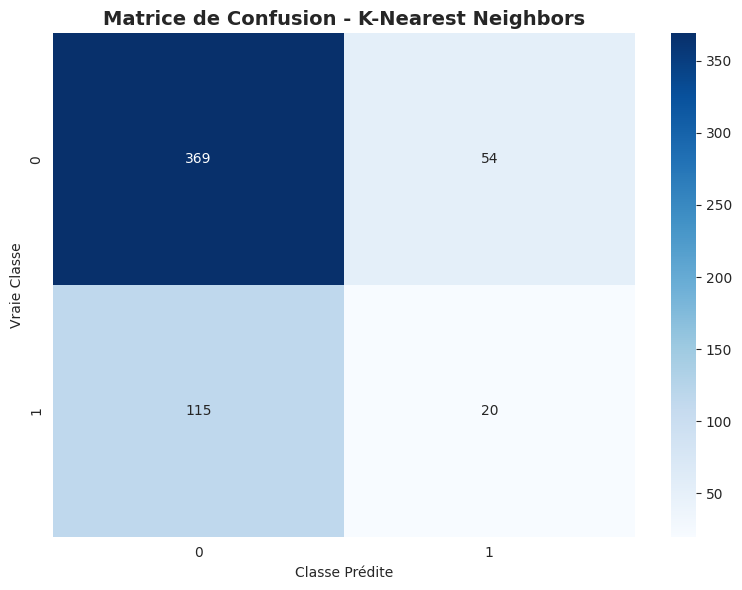


Rapport de classification:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       423
           1       0.27      0.15      0.19       135

    accuracy                           0.70       558
   macro avg       0.52      0.51      0.50       558
weighted avg       0.64      0.70      0.66       558



In [11]:
 # Entraînement du modèle KNN
print("Entraînement du modèle K-Nearest Neighbors...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)



# Évaluation
results_knn = evaluate_model('K-Nearest Neighbors', knn,
                             X_train_scaled, X_test_scaled,
                             y_train, y_test)

## 3.3 Logistic Regression

Entraînement du modèle Logistic Regression...

MODÈLE: Logistic Regression
Accuracy Train      : 0.7593
Accuracy Test       : 0.7545
Precision           : 0.6352
Recall              : 0.7545
F1-Score            : 0.6552
ROC-AUC             : 0.5479


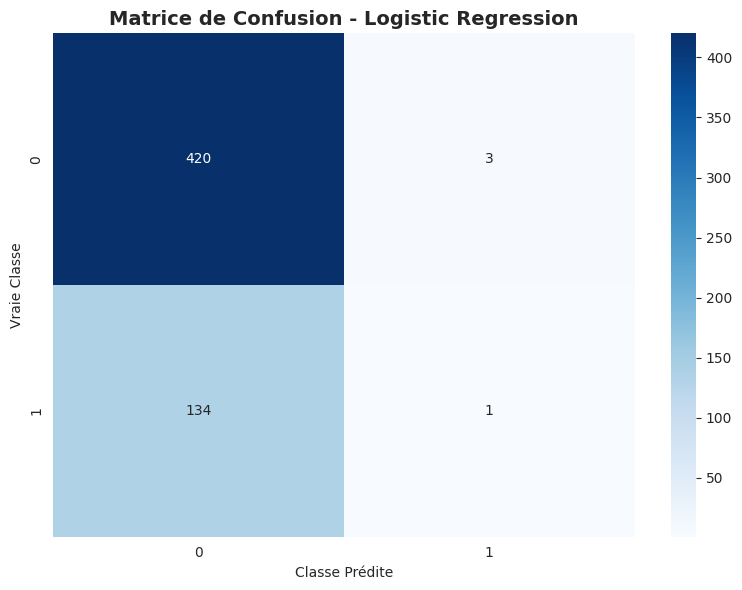


Rapport de classification:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       423
           1       0.25      0.01      0.01       135

    accuracy                           0.75       558
   macro avg       0.50      0.50      0.44       558
weighted avg       0.64      0.75      0.66       558



In [12]:
# Entraînement du modèle Logistic Regression
print("Entraînement du modèle Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Évaluation
results_lr = evaluate_model('Logistic Regression', lr,
                            X_train_scaled, X_test_scaled,
                            y_train, y_test)

## 3.4 Decision Tree avec visualisation

Entraînement du modèle Decision Tree...

MODÈLE: Decision Tree
Accuracy Train      : 0.8610
Accuracy Test       : 0.8405
Precision           : 0.8328
Recall              : 0.8405
F1-Score            : 0.8341
ROC-AUC             : 0.8746


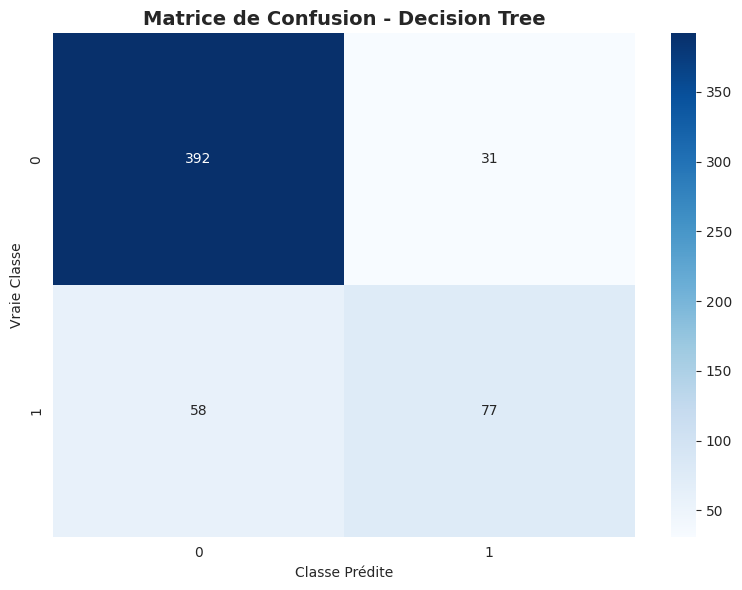


Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       423
           1       0.71      0.57      0.63       135

    accuracy                           0.84       558
   macro avg       0.79      0.75      0.77       558
weighted avg       0.83      0.84      0.83       558



In [13]:
# Entraînement du modèle Decision Tree
print("Entraînement du modèle Decision Tree...")
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_scaled, y_train)

# Évaluation
results_dt = evaluate_model('Decision Tree', dt,
                           X_train_scaled, X_test_scaled,
                           y_train, y_test)

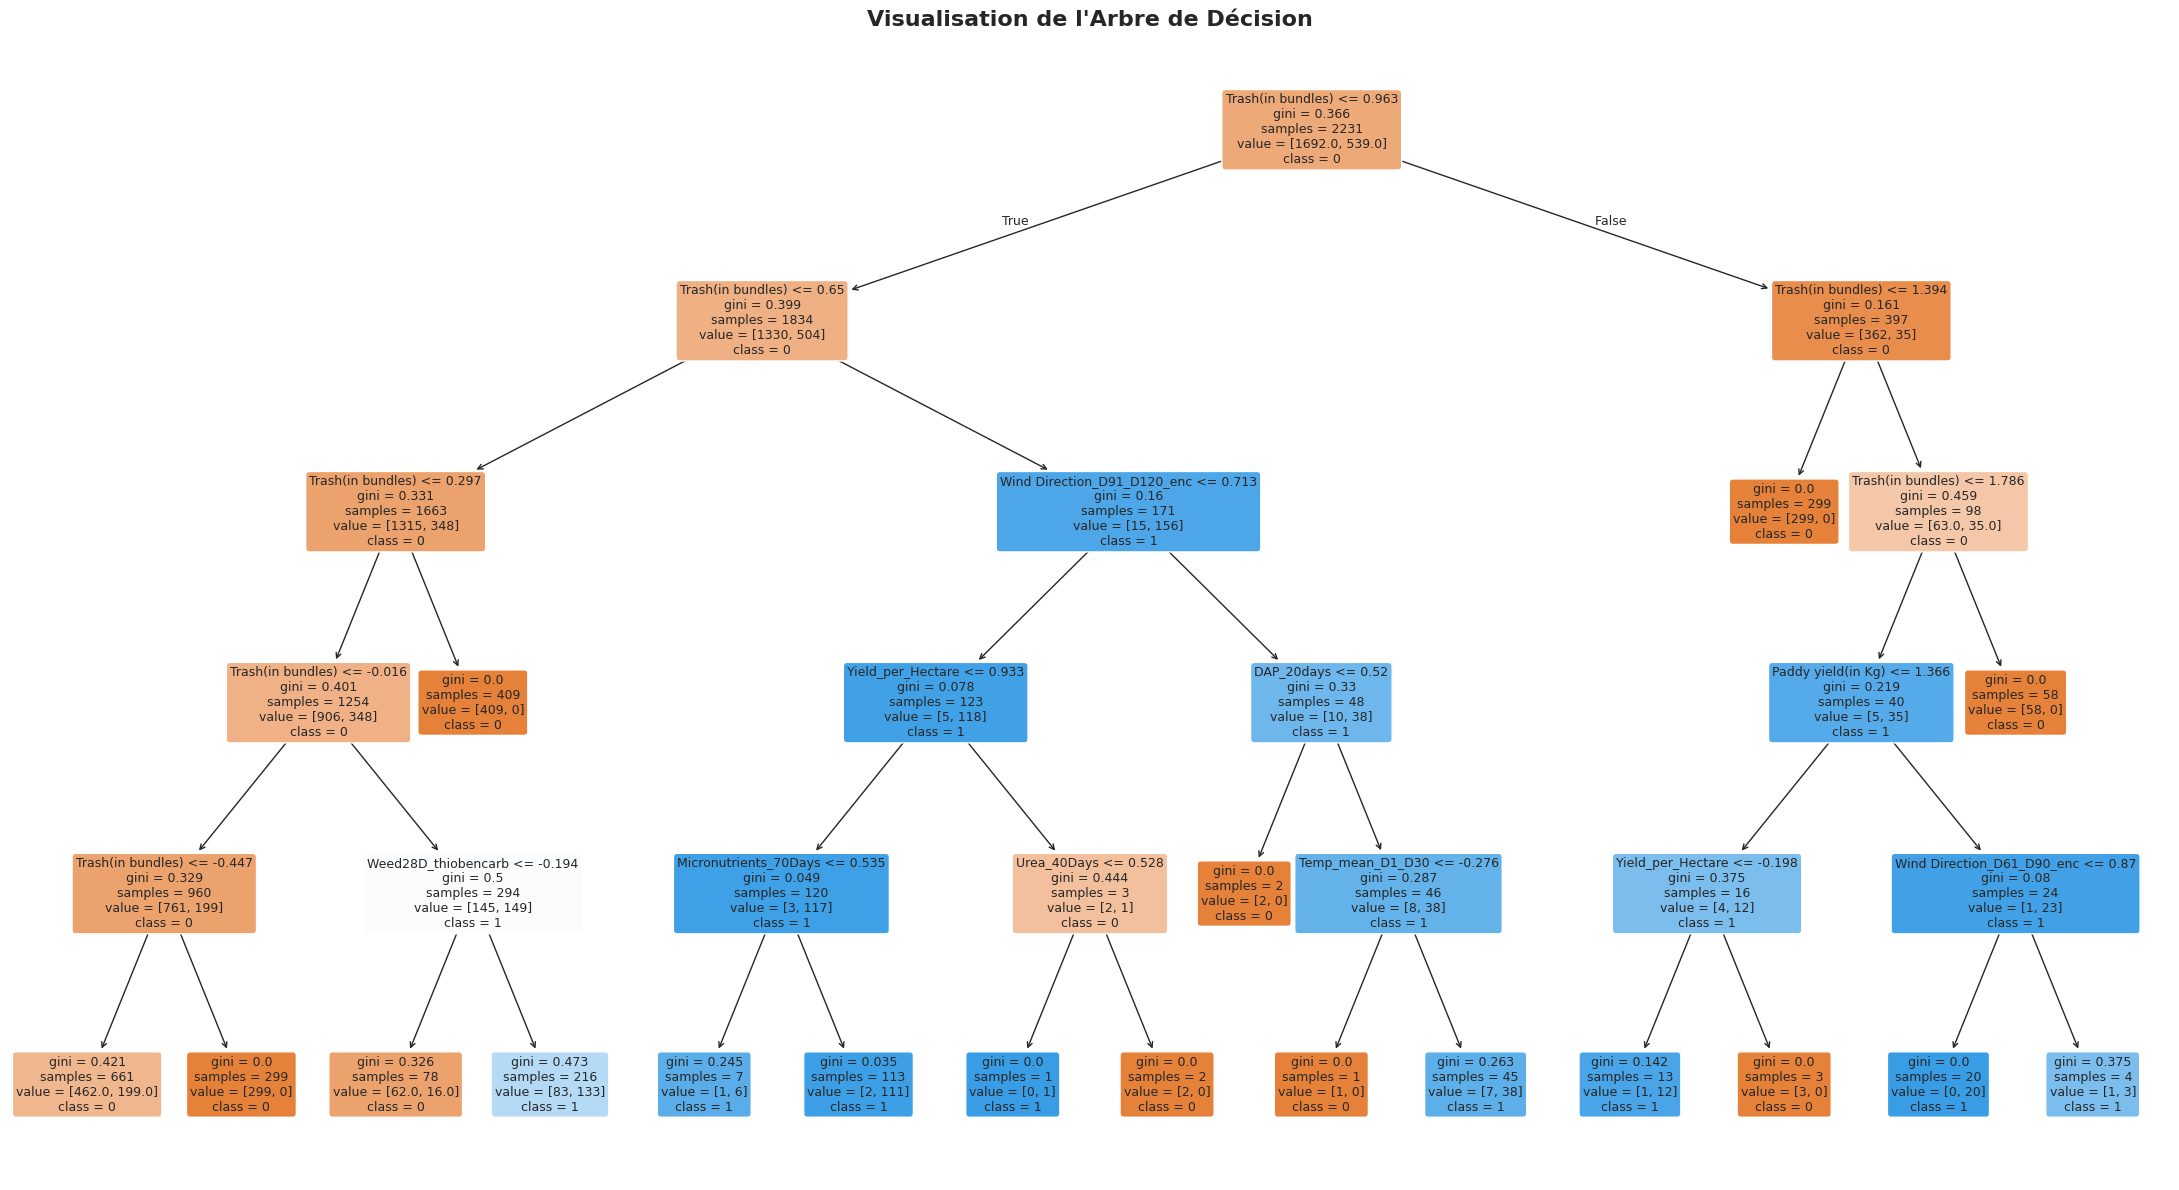

In [15]:
# Visualisation de l'arbre de décision
plt.figure(figsize=(22, 12))

plot_tree(
    dt,                                  # le modèle entraîné
    feature_names=X.columns,             # noms des features
    class_names=dt.classes_.astype(str), # classes réelles
    filled=True,
    rounded=True,
    fontsize=9
)

plt.title("Visualisation de l'Arbre de Décision", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.5 Random Forest avec Feature Importance

Entraînement du modèle Random Forest...

MODÈLE: Random Forest
Accuracy Train      : 1.0000
Accuracy Test       : 0.8513
Precision           : 0.8525
Recall              : 0.8513
F1-Score            : 0.8338
ROC-AUC             : 0.8694


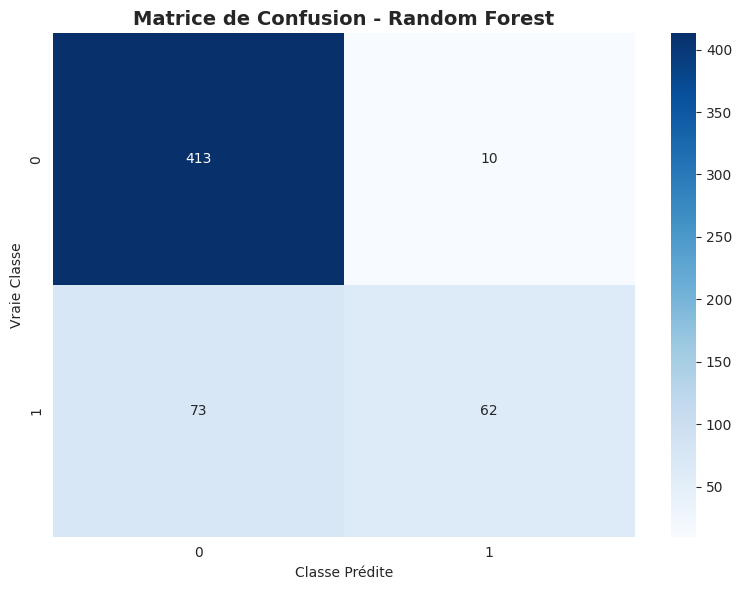


Rapport de classification:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       423
           1       0.86      0.46      0.60       135

    accuracy                           0.85       558
   macro avg       0.86      0.72      0.75       558
weighted avg       0.85      0.85      0.83       558



In [16]:
# Entraînement du modèle Random Forest
print("Entraînement du modèle Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Évaluation
results_rf = evaluate_model('Random Forest', rf,
                           X_train_scaled, X_test_scaled,
                           y_train, y_test)

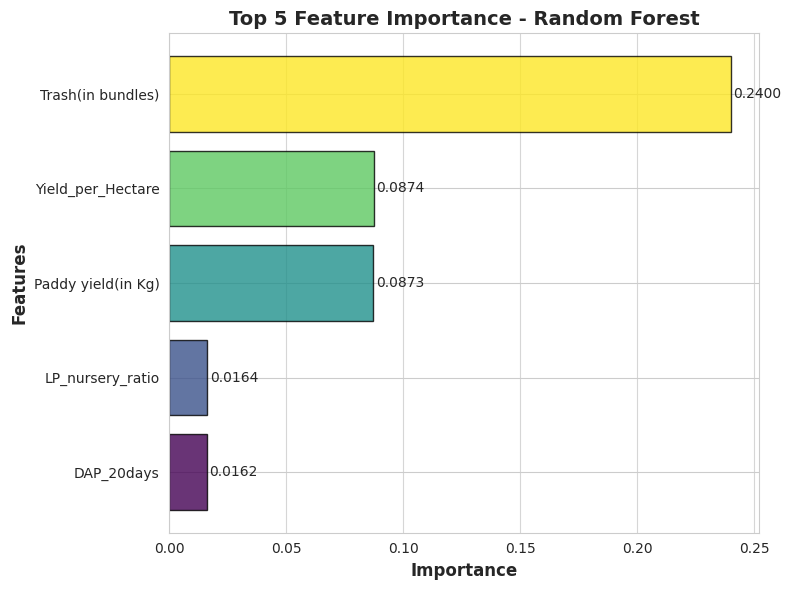


Top 5 Features les plus importantes:
           Feature  Importance
 Trash(in bundles)    0.239969
 Yield_per_Hectare    0.087426
Paddy yield(in Kg)    0.087281
  LP_nursery_ratio    0.016354
        DAP_20days    0.016237


In [18]:
# Trier par importance décroissante
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)

# Sélectionner les Top N features les plus importantes (par ex. top 5)
top_n = 5
top_features = feature_importance_sorted.head(top_n)

# Visualisation avec barres horizontales
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1],
         color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.8)

# Ajouter les valeurs
for i, v in enumerate(top_features['Importance'][::-1]):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Features les plus importantes:")
print(top_features.to_string(index=False))

## 3.6 XGBoost

Entraînement du modèle XGBoost...

MODÈLE: XGBoost
Accuracy Train      : 1.0000
Accuracy Test       : 0.9337
Precision           : 0.9363
Recall              : 0.9337
F1-Score            : 0.9346
ROC-AUC             : 0.9774


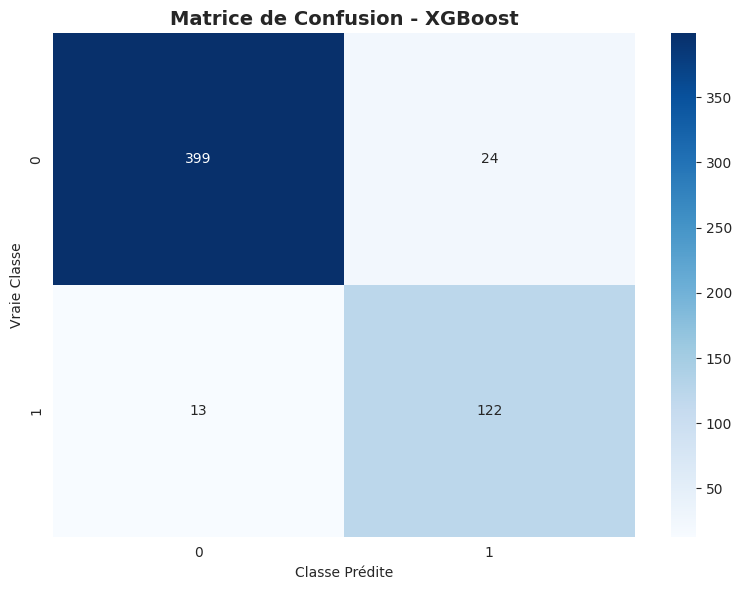


Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       423
           1       0.84      0.90      0.87       135

    accuracy                           0.93       558
   macro avg       0.90      0.92      0.91       558
weighted avg       0.94      0.93      0.93       558



In [19]:
# Entraînement du modèle XGBoost
print("Entraînement du modèle XGBoost...")
xgb = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

# Évaluation
results_xgb = evaluate_model('XGBoost', xgb,
                            X_train_scaled, X_test_scaled,
                            y_train, y_test)

## 3.7 Comparaison des modèles baseline


COMPARAISON DES MODÈLES BASELINE
                     Accuracy Train  Accuracy Test  Precision    Recall  F1-Score   ROC-AUC
Modèle                                                                                     
K-Nearest Neighbors        0.791125       0.697133   0.643334  0.697133  0.663119  0.551931
Logistic Regression        0.759301       0.754480   0.635190  0.754480  0.655246  0.547903
Decision Tree              0.861049       0.840502   0.832849  0.840502  0.834107  0.874608
Random Forest              1.000000       0.851254   0.852532  0.851254  0.833774  0.869355
XGBoost                    1.000000       0.933692   0.936310  0.933692  0.934553  0.977445


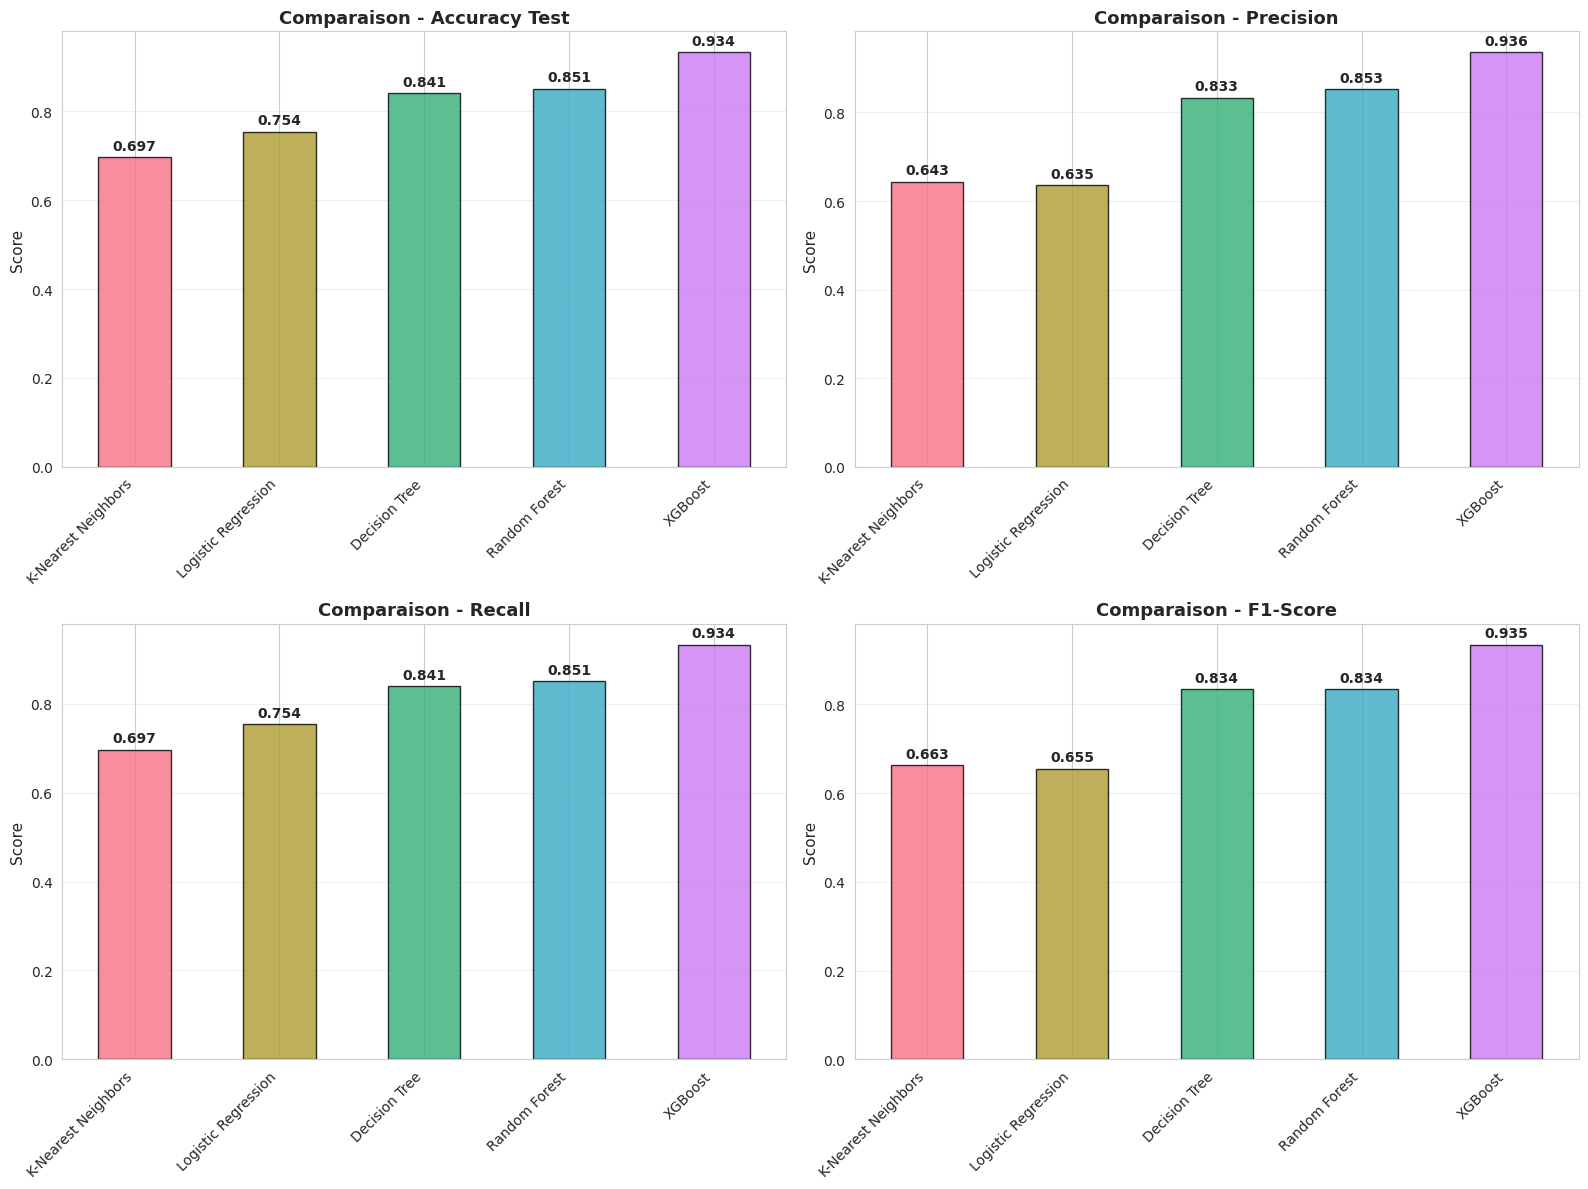

In [20]:
# Comparaison des résultats
comparison_df = pd.DataFrame([results_knn, results_lr, results_dt, results_rf, results_xgb])
comparison_df = comparison_df.set_index('Modèle')

print("\n" + "="*100)
print("COMPARAISON DES MODÈLES BASELINE")
print("="*100)
print(comparison_df.to_string())

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy Test', 'Precision', 'Recall', 'F1-Score']
colors_palette = sns.color_palette('husl', len(comparison_df))

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2

    comparison_df[metric].plot(kind='bar', ax=axes[row, col],
                               color=colors_palette, alpha=0.8, edgecolor='black')
    axes[row, col].set_title(f'Comparaison - {metric}', fontsize=13, fontweight='bold')
    axes[row, col].set_ylabel('Score', fontsize=11)
    axes[row, col].set_xlabel('')
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')

    # Ajouter les valeurs sur les barres
    for i, v in enumerate(comparison_df[metric]):
        axes[row, col].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [22]:
print("\n=== MODÈLES SANS PCA ===")

# ==============================
# Decision Trees
# ==============================
dt_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    random_state=42
)

dt_entropy = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=42
)

dt_gini.fit(X_train_scaled, y_train)
dt_entropy.fit(X_train_scaled, y_train)

y_pred_dt_gini = dt_gini.predict(X_test_scaled)
y_pred_dt_entropy = dt_entropy.predict(X_test_scaled)

print("\nDecision Tree - Gini")
print(classification_report(y_test, y_pred_dt_gini))
print("Accuracy :", accuracy_score(y_test, y_pred_dt_gini))
print("F1-score :", f1_score(y_test, y_pred_dt_gini, average='weighted'))

print("\nDecision Tree - Entropy")
print(classification_report(y_test, y_pred_dt_entropy))
print("Accuracy :", accuracy_score(y_test, y_pred_dt_entropy))
print("F1-score :", f1_score(y_test, y_pred_dt_entropy, average='weighted'))


# ==============================
# Random Forest
# ==============================
rf_gini = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    random_state=42
)

rf_entropy = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=42
)

rf_gini.fit(X_train_scaled, y_train)
rf_entropy.fit(X_train_scaled, y_train)

y_pred_rf_gini = rf_gini.predict(X_test_scaled)
y_pred_rf_entropy = rf_entropy.predict(X_test_scaled)

print("\nRandom Forest - Gini")
print(classification_report(y_test, y_pred_rf_gini))
print("Accuracy :", accuracy_score(y_test, y_pred_rf_gini))
print("F1-score :", f1_score(y_test, y_pred_rf_gini, average='weighted'))

print("\nRandom Forest - Entropy")
print(classification_report(y_test, y_pred_rf_entropy))
print("Accuracy :", accuracy_score(y_test, y_pred_rf_entropy))
print("F1-score :", f1_score(y_test, y_pred_rf_entropy, average='weighted'))


=== MODÈLES SANS PCA ===

Decision Tree - Gini
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       423
           1       0.71      0.57      0.63       135

    accuracy                           0.84       558
   macro avg       0.79      0.75      0.77       558
weighted avg       0.83      0.84      0.83       558

Accuracy : 0.8405017921146953
F1-score : 0.8341072476977587

Decision Tree - Entropy
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       423
           1       0.71      0.57      0.63       135

    accuracy                           0.84       558
   macro avg       0.79      0.75      0.77       558
weighted avg       0.83      0.84      0.83       558

Accuracy : 0.8405017921146953
F1-score : 0.8341072476977587

Random Forest - Gini
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       423
           1       0.8

Le but d’utiliser Gini ou Entropie dans les arbres de décision et les forêts aléatoires est le même :

`Trouver la meilleure séparation possible à chaque nœud pour que les sous-nœuds soient les plus purs possibles.`

Autrement dit :

- On veut que chaque branche contienne des exemples aussi homogènes que possible (ex. tous de la même classe).

- Gini et Entropie sont juste deux façons différentes de mesurer l’impureté ou le désordre d’un nœud.

- L’arbre utilise cette mesure pour décider quelle variable et quelle valeur de split choisir à chaque étape.

---
# 4. Fine-tuning des Meilleurs Modèles
---

## 4.1 Sélection des meilleurs modèles

In [23]:
# Sélection des 3 meilleurs modèles basés sur le F1-Score
best_models_idx = comparison_df['F1-Score'].nlargest(3).index
print("Top 3 modèles sélectionnés pour le fine-tuning:")
print("="*80)
for i, model_name in enumerate(best_models_idx, 1):
    print(f"{i}. {model_name} - F1-Score: {comparison_df.loc[model_name, 'F1-Score']:.4f}")

Top 3 modèles sélectionnés pour le fine-tuning:
1. XGBoost - F1-Score: 0.9346
2. Decision Tree - F1-Score: 0.8341
3. Random Forest - F1-Score: 0.8338


## 4.2 Fine-tuning avec GridSearchCV


FINE-TUNING: Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Meilleurs paramètres trouvés:
  C: 0.1
  penalty: l2
  solver: lbfgs

Meilleur score (F1) en validation croisée: 0.0072

MODÈLE: Logistic Regression (Tuned)
Accuracy Train      : 0.7602
Accuracy Test       : 0.7563
Precision           : 0.5743
Recall              : 0.7563
F1-Score            : 0.6529
ROC-AUC             : 0.5476


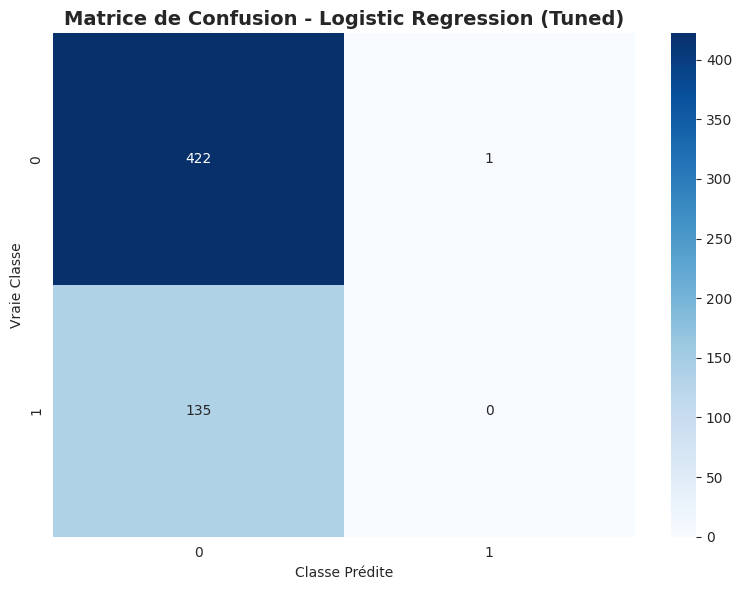


Rapport de classification:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       423
           1       0.00      0.00      0.00       135

    accuracy                           0.76       558
   macro avg       0.38      0.50      0.43       558
weighted avg       0.57      0.76      0.65       558


FINE-TUNING: Random Forest
Fitting 5 folds for each of 135 candidates, totalling 675 fits

Meilleurs paramètres trouvés:
  max_depth: None
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 300

Meilleur score (F1) en validation croisée: 0.5534

MODÈLE: Random Forest (Tuned)
Accuracy Train      : 1.0000
Accuracy Test       : 0.8441
Precision           : 0.8427
Recall              : 0.8441
F1-Score            : 0.8258
ROC-AUC             : 0.8761


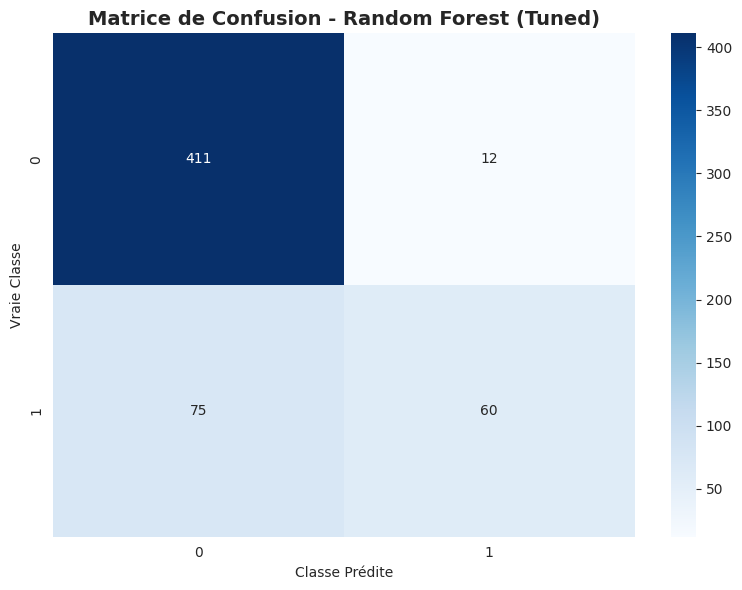


Rapport de classification:
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       423
           1       0.83      0.44      0.58       135

    accuracy                           0.84       558
   macro avg       0.84      0.71      0.74       558
weighted avg       0.84      0.84      0.83       558


FINE-TUNING: XGBoost
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Meilleurs paramètres trouvés:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 100
  subsample: 0.8

Meilleur score (F1) en validation croisée: 0.9082

MODÈLE: XGBoost (Tuned)
Accuracy Train      : 0.9579
Accuracy Test       : 0.9498
Precision           : 0.9529
Recall              : 0.9498
F1-Score            : 0.9506
ROC-AUC             : 0.9817


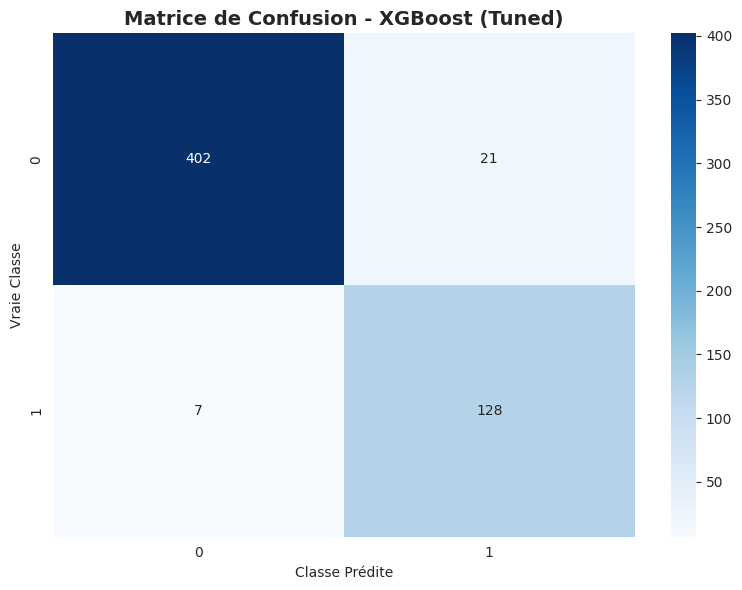


Rapport de classification:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       423
           1       0.86      0.95      0.90       135

    accuracy                           0.95       558
   macro avg       0.92      0.95      0.93       558
weighted avg       0.95      0.95      0.95       558



In [24]:
# Dictionnaire des modèles et paramètres à tuner
models_to_tune = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    }
}

# Stockage des modèles tunés
tuned_models = {}
tuned_results = []

for model_name, config in models_to_tune.items():
    print(f"\n{'='*80}")
    print(f"FINE-TUNING: {model_name}")
    print(f"{'='*80}")

    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"\nMeilleurs paramètres trouvés:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

    print(f"\nMeilleur score (F1) en validation croisée: {grid_search.best_score_:.4f}")

    # Stocker le meilleur modèle
    tuned_models[model_name] = grid_search.best_estimator_

    # Évaluation sur le test set
    results = evaluate_model(f'{model_name} (Tuned)',
                            grid_search.best_estimator_,
                            X_train_scaled, X_test_scaled,
                            y_train, y_test)
    tuned_results.append(results)

## 4.3 Comparaison Avant/Après Fine-tuning


COMPARAISON DES MODÈLES APRÈS FINE-TUNING
                             Accuracy Train  Accuracy Test  Precision    Recall  F1-Score   ROC-AUC
Modèle                                                                                             
Logistic Regression (Tuned)        0.760197       0.756272   0.574333  0.756272  0.652864  0.547588
Random Forest (Tuned)              1.000000       0.844086   0.842692  0.844086  0.825763  0.876114
XGBoost (Tuned)                    0.957866       0.949821   0.952928  0.949821  0.950635  0.981700


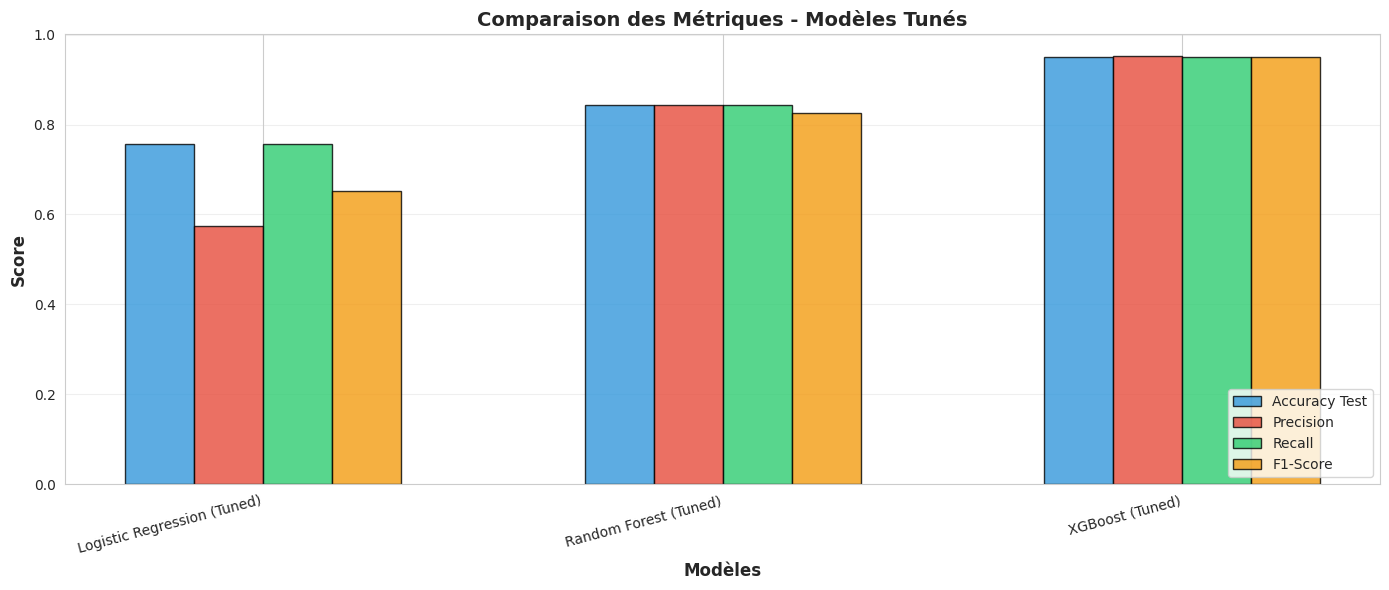

In [25]:
# Comparaison des résultats
tuned_comparison_df = pd.DataFrame(tuned_results).set_index('Modèle')

print("\n" + "="*100)
print("COMPARAISON DES MODÈLES APRÈS FINE-TUNING")
print("="*100)
print(tuned_comparison_df.to_string())

# Visualisation comparative
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(tuned_comparison_df))
width = 0.15

metrics = ['Accuracy Test', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, tuned_comparison_df[metric], width,
           label=metric, color=color, alpha=0.8, edgecolor='black')

ax.set_xlabel('Modèles', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des Métriques - Modèles Tunés', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(tuned_comparison_df.index, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Performance générale :**

- XGBoost a la meilleure accuracy, precision, recall, F1-score, et ROC-AUC, ce qui montre qu’il excelle à la fois sur la détection des classes et la généralisation.

**Overfitting :**

- Random Forest a 100% de précision sur le train, mais perd un peu en test (0.844), ce qui montre un léger surapprentissage.

- XGBoost reste très performant sur le test (0.950) tout en ayant une accuracy train légèrement inférieure à 1 (0.958), ce qui montre un bon équilibre.

**ROC-AUC :**

- XGBoost atteint 0.982, ce qui est excellent et indique qu’il sépare très bien les classes positives et négatives.

> Conclusion : Pour ce dataset, XGBoost (Tuned) est le modèle à retenir pour les prédictions.

## 4.4 Courbes ROC des modèles tunés

Logistic Regression      : ROC-AUC = 0.5476


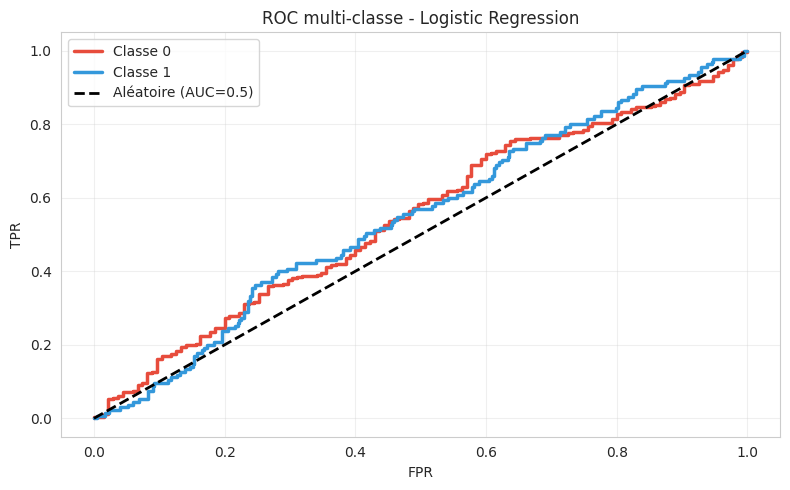

Random Forest            : ROC-AUC = 0.8761


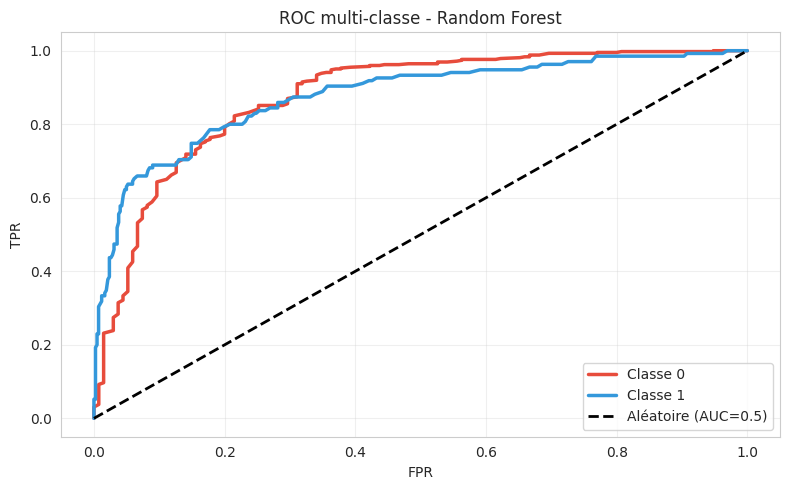

XGBoost                  : ROC-AUC = 0.9817


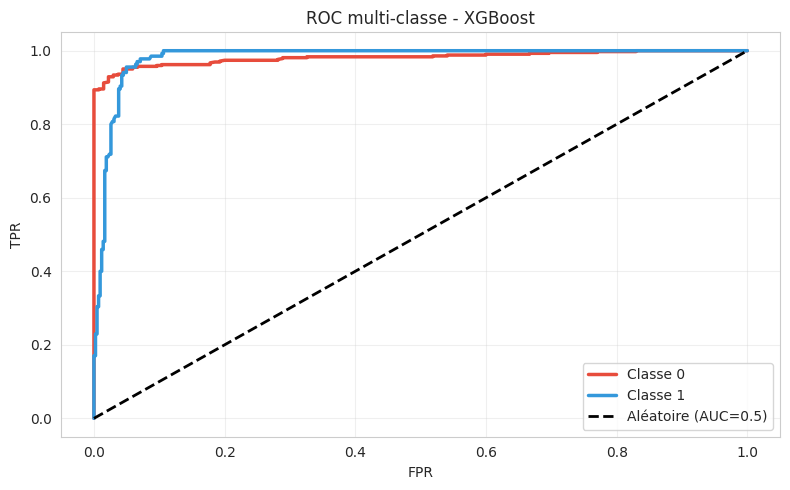

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

colors = ['#e74c3c', '#3498db', '#2ecc71']

# Convertir y_test en 1D si nécessaire
if isinstance(y_test, np.ndarray) and y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)  # convertit one-hot en labels 1D
else:
    y_test_labels = y_test.flatten()  # si déjà 1D

# Boucle pour chaque modèle tuné
for model_name, model in tuned_models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)

    # ROC-AUC multi-classe (One-vs-Rest)
    roc_auc = roc_auc_score(y_test_labels, y_pred_proba[:, 1])
    print(f"{model_name:25s}: ROC-AUC = {roc_auc:.4f}")

    # Tracer les courbes ROC
    plt.figure(figsize=(8,5))
    for i, color in zip(range(y_pred_proba.shape[1]), colors):
        fpr, tpr, _ = roc_curve(y_test_labels == i, y_pred_proba[:, i])
        plt.plot(fpr, tpr, color=color, lw=2.5, label=f'Classe {i}')

    plt.plot([0,1], [0,1], 'k--', lw=2, label='Aléatoire (AUC=0.5)')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC multi-classe - {model_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Comparaison des modèles (ROC-AUC multi-classe)
- XGBoost : Courbes très hautes et proches du coin supérieur gauche → très bonne séparation des 3 classes.
- Random Forest : Bonnes courbes, un peu moins nettes que XGBoost.
- Logistic Regression : Courbes basses, surtout pour la classe rouge → difficulté à séparer les classes (modèle trop simple).

---
# 5. Sélection de Caractéristiques avec SelectKBest
---

## 5.1 Sélection des K meilleures features

In [40]:
# SelectKBest avec différentes valeurs de K
k_values = [5, 7, 10]
feature_selection_results = []

for k in k_values:
    print(f"\n{'='*80}")
    print(f"SÉLECTION DES {k} MEILLEURES FEATURES")
    print(f"{'='*80}")

    # SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Obtenir les noms des features sélectionnées
    selected_features = X.columns[selector.get_support()].tolist()

    print(f"\nFeatures sélectionnées ({k}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"  {i}. {feature}")

    # Scores des features
    feature_scores = pd.DataFrame({
        'Feature': X.columns[selector.get_support()],
        'Score': selector.scores_[selector.get_support()]
    }).sort_values('Score', ascending=False)

    print(f"\nScores des features:")
    print(feature_scores.to_string(index=False))

    # Tester avec différents modèles
    models_test = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    }

    for model_name, model in models_test.items():
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        feature_selection_results.append({
            'K': k,
            'Modèle': model_name,
            'Accuracy': accuracy,
            'F1-Score': f1
        })

        print(f"\n{model_name} avec {k} features:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score: {f1:.4f}")


SÉLECTION DES 5 MEILLEURES FEATURES

Features sélectionnées (5):
  1. Max temp_D91_D120
  2. Inst Wind Speed_D31_D60(in Knots)
  3. Wind Direction_D61_D90_se
  4. Wind Direction_D61_D90_sw
  5. Wind Direction_D91_D120_nw

Scores des features:
                          Feature    Score
        Wind Direction_D61_D90_sw 3.584761
        Wind Direction_D61_D90_se 2.431497
       Wind Direction_D91_D120_nw 1.984853
Inst Wind Speed_D31_D60(in Knots) 1.799390
                Max temp_D91_D120 1.799056

Logistic Regression avec 5 features:
  Accuracy: 0.7581
  F1-Score: 0.6537

Random Forest avec 5 features:
  Accuracy: 0.7563
  F1-Score: 0.6529

XGBoost avec 5 features:
  Accuracy: 0.7545
  F1-Score: 0.6520

SÉLECTION DES 7 MEILLEURES FEATURES

Features sélectionnées (7):
  1. Max temp_D31_D60
  2. Max temp_D91_D120
  3. Inst Wind Speed_D31_D60(in Knots)
  4. Yield_per_Hectare
  5. Wind Direction_D61_D90_se
  6. Wind Direction_D61_D90_sw
  7. Wind Direction_D91_D120_nw

Scores des features:

**Logistic Regression**

- Très stable : Accuracy = 0.7581 quelle que soit la sélection (5, 7 ou 10 features).

- F1-Score stable à ~0.654.

- Cela montre que ce modèle est peu sensible à l’ajout de features supplémentaires pour ce dataset.

**Random Forest**

- Performance chute quand on ajoute plus de features (10 features → accuracy 0.6720).

- Avec 7 features, F1-Score est le plus haut (0.6805), ce qui suggère que certaines features supplémentaires peuvent introduire du bruit pour ce modèle.

**XGBoost**

- Avec 5 features : accuracy 0.7545, F1 0.6520 → proche de RF et LR.

- Avec 7 features : légère amélioration (accuracy 0.7186, F1 0.6608).

- Avec 10 features : meilleure combinaison (accuracy 0.7276, F1 0.6726).

- Indique que XGBoost bénéficie d’un peu plus de features, mais pas trop non plus.

**Top features selon l’importance**

- Wind Direction_D61_D90_sw → Score 3.58

- Wind Direction_D61_D90_se → Score 2.43

- Wind Direction_D91_D120_nw → Score 1.98

- Inst Wind Speed_D31_D60 → Score 1.79

- Max temp_D91_D120 → Score 1.79

> Ces features météo semblent être les plus influentes sur le rendement du paddy, ce qui est cohérent avec la logique agronomique (direction du vent et température ont un impact sur le rendement).

## 5.2 Visualisation des scores avec SelectKBest

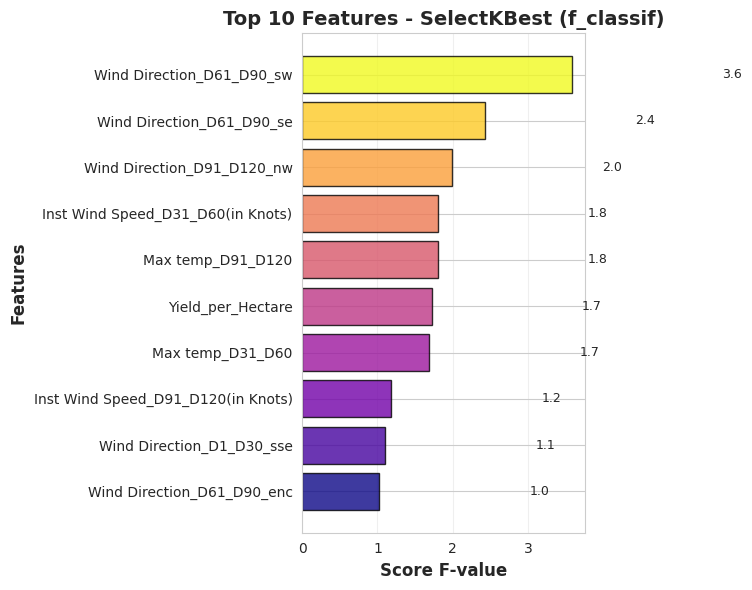

In [45]:
# Visualiser tous les scores des features
# Limiter aux 10 features avec le score le plus élevé
top_n = 10
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X_train_scaled, y_train)

all_feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_all.scores_
}).sort_values('Score', ascending=True)
top_features = all_feature_scores.sort_values('Score', ascending=False).head(top_n)

# Visualisation avec barres horizontales
plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(top_features)))
plt.barh(top_features['Feature'][::-1], top_features['Score'][::-1],  # inversé pour afficher la plus haute en haut
         color=colors, edgecolor='black', alpha=0.8)
plt.xlabel('Score F-value', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features - SelectKBest (f_classif)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(top_features['Score'][::-1]):
    plt.text(v + 2, i, f'{v:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5.3 Comparaison des performances avec différents K


RÉSULTATS DE LA SÉLECTION DE FEATURES
 K              Modèle  Accuracy  F1-Score
 5 Logistic Regression  0.758065  0.653744
 5       Random Forest  0.756272  0.652864
 5             XGBoost  0.754480  0.651982
 7 Logistic Regression  0.758065  0.653744
 7       Random Forest  0.711470  0.680535
 7             XGBoost  0.718638  0.660781
10 Logistic Regression  0.758065  0.653744
10       Random Forest  0.672043  0.651585
10             XGBoost  0.727599  0.672594


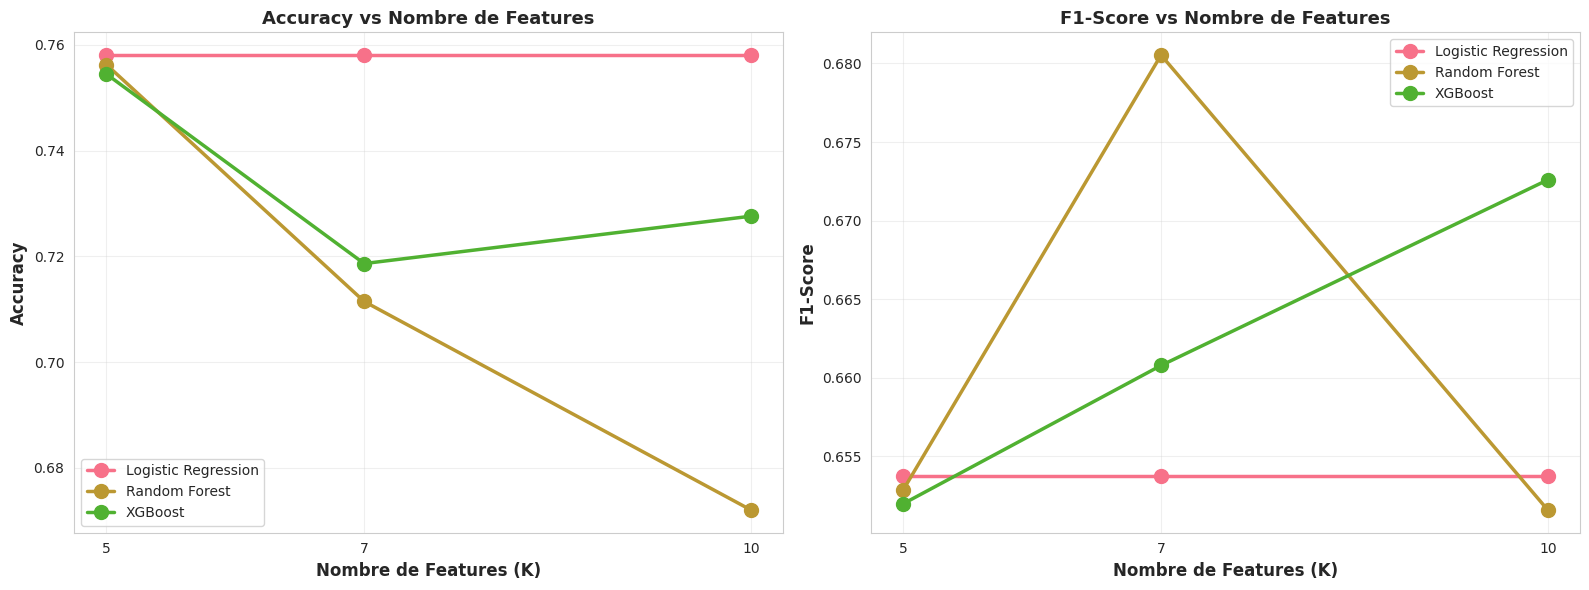

In [46]:
# Comparaison des résultats
fs_results_df = pd.DataFrame(feature_selection_results)

print("\n" + "="*100)
print("RÉSULTATS DE LA SÉLECTION DE FEATURES")
print("="*100)
print(fs_results_df.to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
for model_name in fs_results_df['Modèle'].unique():
    model_data = fs_results_df[fs_results_df['Modèle'] == model_name]
    axes[0].plot(model_data['K'], model_data['Accuracy'],
                marker='o', linewidth=2.5, markersize=10, label=model_name)

axes[0].set_xlabel('Nombre de Features (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Accuracy vs Nombre de Features', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(k_values)

# F1-Score
for model_name in fs_results_df['Modèle'].unique():
    model_data = fs_results_df[fs_results_df['Modèle'] == model_name]
    axes[1].plot(model_data['K'], model_data['F1-Score'],
                marker='o', linewidth=2.5, markersize=10, label=model_name)

axes[1].set_xlabel('Nombre de Features (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('F1-Score vs Nombre de Features', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xticks(k_values)

plt.tight_layout()
plt.show()

**Interprétation**

1. Logistic Regression

- Stable à 0.758 d’accuracy quelle que soit la taille K des features.

- F1-Score stable aussi (~0.654).

- Peu sensible à l’ajout de features supplémentaires → le modèle est simple et linéaire.

2. Random Forest

- F1-Score augmente légèrement avec 7 features (0.6805), mais baisse pour 10 features (0.6516).

- Indique que certaines features supplémentaires ajoutent du bruit et dégradent la performance.

3. XGBoost

- Performances améliorent avec 10 features (F1-Score 0.6726, Accuracy 0.7276) → peut mieux gérer les interactions entre features.

- Moins stable avec peu de features, mais gagne en complexité avec plus de variables.

In [48]:
# Créer le dossier si nécessaire
os.makedirs("classification", exist_ok=True)

# Trouver le meilleur modèle selon F1-Score
best_result = max(feature_selection_results, key=lambda x: x['F1-Score'])
best_k = best_result['K']
best_model_name = best_result['Modèle']

print(f"Meilleur modèle : {best_model_name} avec K={best_k} features, F1-Score={best_result['F1-Score']:.4f}")

# Re-créer et entraîner le modèle correspondant pour sauvegarde
selector_best = SelectKBest(score_func=f_classif, k=best_k)
X_train_best = selector_best.fit_transform(X_train_scaled, y_train)
X_test_best = selector_best.transform(X_test_scaled)

selected_features_best = X.columns[selector_best.get_support()].tolist()
print(f"Features sélectionnées pour le meilleur modèle : {selected_features_best}")

# Créer le modèle
if best_model_name == 'XGBoost':
    model_best = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
elif best_model_name == 'Random Forest':
    model_best = RandomForestClassifier(n_estimators=100, random_state=42)
else:
    model_best = LogisticRegression(max_iter=1000, random_state=42)

# Entraînement
model_best.fit(X_train_best, y_train)

# Sauvegarde
joblib.dump(model_best, f"classification/best_model_{best_model_name}_K{best_k}.pkl")
print(f"Modèle {best_model_name} sauvegardé avec succès !")

Meilleur modèle : Random Forest avec K=7 features, F1-Score=0.6805
Features sélectionnées pour le meilleur modèle : ['Max temp_D31_D60', 'Max temp_D91_D120', 'Inst Wind Speed_D31_D60(in Knots)', 'Yield_per_Hectare', 'Wind Direction_D61_D90_se', 'Wind Direction_D61_D90_sw', 'Wind Direction_D91_D120_nw']
Modèle Random Forest sauvegardé avec succès !
